# Phase 5 Project: *Title*

### By Ryan Posternak

Flatiron School, Full-Time Live NYC<br>
Project Presentation Date: August 26th, 2022<br>
Instructor: Joseph Mata

## Goal: 

*This is a project for learning purposes. The *** is not involved with this project in any way.*

<br>

# Overview and Business Understanding

<br>

# Data Understanding

<br>

# Initial Exploratory Data Analysis

### Import libraries, packages and modules

In [1]:
import numpy as np
import pandas as pd

from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import StringType, IntegerType, DoubleType
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
# from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns
%matplotlib inline

In [2]:
# Initialize Spark Session
spark = SparkSession.builder.master('local[8]').getOrCreate()

In [3]:
# Read in training data csv to a Spark DataFrame
spark_X_df = spark.read.csv('data/Richters_Predictor_Modeling_Earthquake_Damage_-_Train_Values.csv', header=True)

# Read in testing data csv to a Spark DataFrame
spark_y_df = spark.read.csv('data/Richters_Predictor_Modeling_Earthquake_Damage_-_Train_Labels.csv', header=True)

In [4]:
# Print shape of dataframe
print(f"Rows: {spark_X_df.count()}, Columns: {len(spark_X_df.columns)}")

Rows: 260601, Columns: 39


In [5]:
# Print features dataframe schema
spark_X_df.printSchema()

root
 |-- building_id: string (nullable = true)
 |-- geo_level_1_id: string (nullable = true)
 |-- geo_level_2_id: string (nullable = true)
 |-- geo_level_3_id: string (nullable = true)
 |-- count_floors_pre_eq: string (nullable = true)
 |-- age: string (nullable = true)
 |-- area_percentage: string (nullable = true)
 |-- height_percentage: string (nullable = true)
 |-- land_surface_condition: string (nullable = true)
 |-- foundation_type: string (nullable = true)
 |-- roof_type: string (nullable = true)
 |-- ground_floor_type: string (nullable = true)
 |-- other_floor_type: string (nullable = true)
 |-- position: string (nullable = true)
 |-- plan_configuration: string (nullable = true)
 |-- has_superstructure_adobe_mud: string (nullable = true)
 |-- has_superstructure_mud_mortar_stone: string (nullable = true)
 |-- has_superstructure_stone_flag: string (nullable = true)
 |-- has_superstructure_cement_mortar_stone: string (nullable = true)
 |-- has_superstructure_mud_mortar_brick: str

In [6]:
# Print first row
spark_X_df.show(n=1, vertical=True)

-RECORD 0----------------------------------------
 building_id                            | 802906 
 geo_level_1_id                         | 6      
 geo_level_2_id                         | 487    
 geo_level_3_id                         | 12198  
 count_floors_pre_eq                    | 2      
 age                                    | 30     
 area_percentage                        | 6      
 height_percentage                      | 5      
 land_surface_condition                 | t      
 foundation_type                        | r      
 roof_type                              | n      
 ground_floor_type                      | f      
 other_floor_type                       | q      
 position                               | t      
 plan_configuration                     | d      
 has_superstructure_adobe_mud           | 1      
 has_superstructure_mud_mortar_stone    | 1      
 has_superstructure_stone_flag          | 0      
 has_superstructure_cement_mortar_stone | 0      


In [7]:
# Show unique values for each column through Pandas
spark_X_df.toPandas().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260601 entries, 0 to 260600
Data columns (total 39 columns):
 #   Column                                  Non-Null Count   Dtype 
---  ------                                  --------------   ----- 
 0   building_id                             260601 non-null  object
 1   geo_level_1_id                          260601 non-null  object
 2   geo_level_2_id                          260601 non-null  object
 3   geo_level_3_id                          260601 non-null  object
 4   count_floors_pre_eq                     260601 non-null  object
 5   age                                     260601 non-null  object
 6   area_percentage                         260601 non-null  object
 7   height_percentage                       260601 non-null  object
 8   land_surface_condition                  260601 non-null  object
 9   foundation_type                         260601 non-null  object
 10  roof_type                               260601 non-null 

In [ ]:
# Show unique values for each column through PySpark
spark_X_df.agg(*(F.countDistinct(F.col(c)).alias('distinct_' + c) for c in spark_X_df.columns)).show(vertical=True)

In [ ]:
# Show null values for each column through PySpark
spark_X_df.select([F.count(F.when(F.isnan(c), c)).alias('null_' + c) for c in spark_X_df.columns]).show(vertical=True)

In [ ]:
# Print summary statistics
drop_cols = ['building_id', 'geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']

spark_X_df.drop(*drop_cols).summary().toPandas()

In [8]:
# Show value_counts for 'damage_grade' column
class_counts = spark_y_df.groupBy('damage_grade').count().withColumn('percent', F.col('count')/spark_y_df.count())

class_counts.toPandas()

,damage_grade,count,percent
0,3,87218,0.334680
1,1,25124,0.096408
2,2,148259,0.568912


<br>

# Preprocessing

Steps:
1. Drop useless columns
2. Unpack any joined data within columns
3. Convert columns to correct datatypes
4. Handle null/missing values (may need to convert some values to np.nan)
5. Impute any missing values

### Convert numerical integer columns to IntegerType

In [9]:
spark_preprocessed_df = spark_X_df.alias('spark_preprocessed_df')

In [10]:
# Convert first set of numerical columns to IntegerType
cols = ['building_id', 'geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'count_floors_pre_eq', 
        'age', 'area_percentage', 'height_percentage']

for col in cols:
    spark_preprocessed_df = spark_preprocessed_df.withColumn(col, spark_preprocessed_df[col].cast(IntegerType()))
    
assert ['int'] * len(cols) == [dtype[1] for dtype in spark_preprocessed_df.select(*cols).dtypes]

In [11]:
# Convert superstructure columns to IntegerType
superstructure_cols = ['has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone', 
                       'has_superstructure_stone_flag', 'has_superstructure_cement_mortar_stone', 
                       'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick', 
                       'has_superstructure_timber', 'has_superstructure_bamboo', 
                       'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered', 
                       'has_superstructure_other']

for col in superstructure_cols:
    spark_preprocessed_df = spark_preprocessed_df.withColumn(col, spark_preprocessed_df[col].cast(IntegerType()))
    
assert ['int'] * len(superstructure_cols) == \
[dtype[1] for dtype in spark_preprocessed_df.select(*superstructure_cols).dtypes]

In [12]:
# Convert secondary_use columns to IntegerType
secondary_use_cols = ['has_secondary_use', 'has_secondary_use_agriculture', 'has_secondary_use_hotel', 
                      'has_secondary_use_rental', 'has_secondary_use_institution', 'has_secondary_use_school', 
                      'has_secondary_use_industry', 'has_secondary_use_health_post', 'has_secondary_use_gov_office', 
                      'has_secondary_use_use_police', 'has_secondary_use_other']

# Convert secondary_use columns above to IntegerType
for col in secondary_use_cols:
    spark_preprocessed_df = spark_preprocessed_df.withColumn(col, spark_preprocessed_df[col].cast(IntegerType()))
    
assert ['int'] * len(secondary_use_cols) == \
[dtype[1] for dtype in spark_preprocessed_df.select(*secondary_use_cols).dtypes]

### Examine `count_families` column

In [13]:
# Show value_counts for 'damage_grade' column
class_counts = spark_preprocessed_df.groupBy('count_families').count()

class_counts.toPandas()

,count_families,count
0,7,7
1,3,1802
2,8,2
3,0,20862
4,5,104
5,6,22
6,9,4
7,1,226115
8,4,389
9,2,11294


In [14]:
# It looks like some values are very rare. Let's combine any values above 4 into 4
spark_preprocessed_df = spark_preprocessed_df.withColumn('count_families', \
                        spark_preprocessed_df['count_families'].cast(IntegerType()))

spark_preprocessed_df = spark_preprocessed_df.replace(to_replace=[5, 6, 7, 8, 9], value=4, subset=['count_families'])

class_counts = spark_preprocessed_df.groupBy('count_families').count()

class_counts.toPandas()

,count_families,count
0,1,226115
1,3,1802
2,4,528
3,2,11294
4,0,20862


### Drop superfluous / useless columns

In [15]:
# Drop 'has_secondary_use' column - redundant
spark_preprocessed_df = spark_preprocessed_df.drop('has_secondary_use')

# Drop 'geo_level_2_id' column - redundant; would increase dimensionality too much
spark_preprocessed_df = spark_preprocessed_df.drop('geo_level_2_id')

# Drop 'geo_level_3_id' column - redundant; would increase dimensionality too much
spark_preprocessed_df = spark_preprocessed_df.drop('geo_level_3_id')

### Show distinct categories for categorical features

In [16]:
for column, dtype in spark_preprocessed_df.dtypes:
    if dtype == 'string':
        spark_preprocessed_df.select(column).distinct().show()

+----------------------+
|land_surface_condition|
+----------------------+
|                     n|
|                     o|
|                     t|
+----------------------+

+---------------+
|foundation_type|
+---------------+
|              h|
|              w|
|              u|
|              i|
|              r|
+---------------+

+---------+
|roof_type|
+---------+
|        x|
|        n|
|        q|
+---------+

+-----------------+
|ground_floor_type|
+-----------------+
|                x|
|                m|
|                f|
|                v|
|                z|
+-----------------+

+----------------+
|other_floor_type|
+----------------+
|               x|
|               q|
|               j|
|               s|
+----------------+

+--------+
|position|
+--------+
|       o|
|       j|
|       t|
|       s|
+--------+

+------------------+
|plan_configuration|
+------------------+
|                 m|
|                 f|
|                 n|
|                 o|
|     

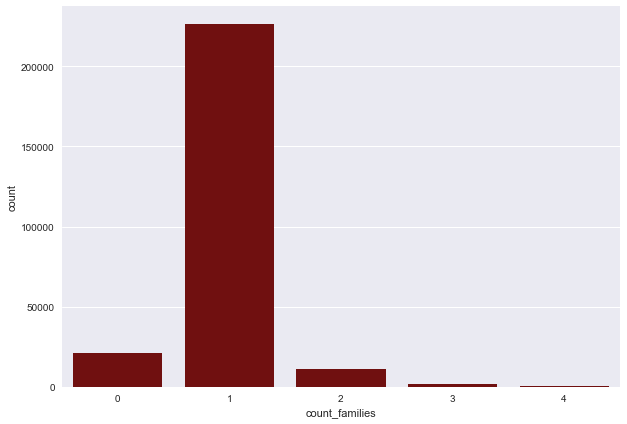

In [17]:
# Plot count_families
count_families_binned_cats = spark_preprocessed_df.groupby('count_families').count()
count_families_binned_cats_df = count_families_binned_cats.toPandas()

fig, ax = plt.subplots(figsize=(10, 7))

sns.barplot(x=count_families_binned_cats_df['count_families'], 
            y=count_families_binned_cats_df['count'], 
            color='maroon');

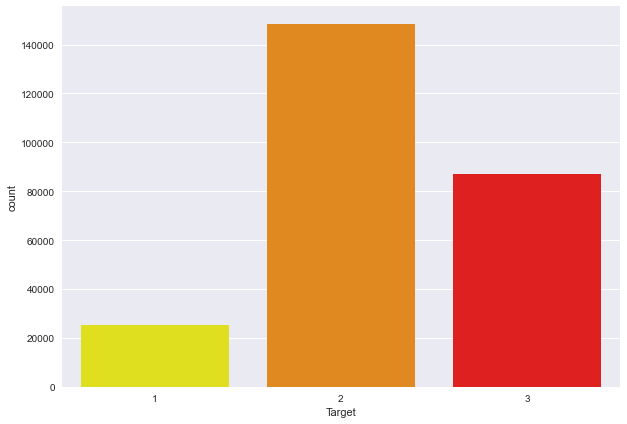

In [18]:
# Group and aggregate target data
damage_grade_counts = spark_y_df.groupBy('damage_grade').count().toPandas()
# Sort by damage grade
damage_grade_counts = damage_grade_counts.sort_values(by='damage_grade')

# Plot target data
# default_counts['default'].replace({0: 'non-defaults', 1: 'defaults'}, inplace=True)

fig, ax = plt.subplots(figsize=(10, 7))
palette = {'1': 'yellow', '2': 'darkorange', '3': 'red'}
sns.barplot(x='damage_grade', y='count', ax=ax, data=damage_grade_counts, palette=palette)
# ax.set_xticklabels(['non-defaults', 'defaults'])
ax.set_xlabel('Target');

In [19]:
# Print target dataframe schema
spark_y_df.printSchema()

root
 |-- building_id: string (nullable = true)
 |-- damage_grade: string (nullable = true)



In [20]:
# Convert target datatypes to IntegerType
spark_y_df = spark_y_df.withColumn('building_id', spark_y_df['building_id'].cast(IntegerType()))
spark_y_df = spark_y_df.withColumn('damage_grade', spark_y_df['damage_grade'].cast(IntegerType()))

<br>

# Create Pipeline to Preprocess and Model Data

### Join features and target dataframes

In [21]:
# Join on 'building_id' values
if not 'damage_grade' in spark_preprocessed_df.columns:
    spark_preprocessed_df = spark_preprocessed_df.join(spark_y_df, on='building_id', how='inner')

assert spark_X_df.count() == spark_preprocessed_df.count()
spark_preprocessed_df.count()

260601

In [22]:
spark_preprocessed_df = spark_preprocessed_df.drop('building_id')

### Index string columns with StringIndexer

In [23]:
stages = []

categoricalCols = [item[0] for item in spark_preprocessed_df.dtypes if item[1].startswith('string')]

indexers = []

for col in categoricalCols:
    indexer = StringIndexer(inputCol=col, outputCol=col + '_index', handleInvalid='keep')
    indexers.append(indexer)
    
indexed_features = []
for si in indexers:
    indexed_features.append(si.getOutputCol())
    
print(f"Indexed string features: \n{indexed_features}")

Indexed string features: 
['land_surface_condition_index', 'foundation_type_index', 'roof_type_index', 'ground_floor_type_index', 'other_floor_type_index', 'position_index', 'plan_configuration_index', 'legal_ownership_status_index']


### Create a OneHotEncoder to encode the indexed string features

In [24]:
encoder = OneHotEncoder(inputCols=indexed_features, 
                        outputCols=[col + '_ohe' for col in indexed_features], 
                        dropLast=True)

print(f"One hot encoded string features: {len(encoder.getOutputCols())}\n{encoder.getOutputCols()}")

One hot encoded string features: 8
['land_surface_condition_index_ohe', 'foundation_type_index_ohe', 'roof_type_index_ohe', 'ground_floor_type_index_ohe', 'other_floor_type_index_ohe', 'position_index_ohe', 'plan_configuration_index_ohe', 'legal_ownership_status_index_ohe']


### Compile numeric features, not including target column

In [25]:
numeric_features = []
for column, dtype in spark_preprocessed_df.dtypes:
    if dtype != 'string' and column != 'damage_grade':
        numeric_features.append(column)

# Confirm equal column counts
assert len(spark_preprocessed_df.drop('damage_grade').columns) == (len(indexed_features) + len(numeric_features))
print(f"Numeric features: {len(numeric_features)}\n{numeric_features}")

Numeric features: 27
['geo_level_1_id', 'count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag', 'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick', 'has_superstructure_timber', 'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered', 'has_superstructure_other', 'count_families', 'has_secondary_use_agriculture', 'has_secondary_use_hotel', 'has_secondary_use_rental', 'has_secondary_use_institution', 'has_secondary_use_school', 'has_secondary_use_industry', 'has_secondary_use_health_post', 'has_secondary_use_gov_office', 'has_secondary_use_use_police', 'has_secondary_use_other']


In [26]:
# Print names of final features going into the model
features = encoder.getOutputCols() + numeric_features
print(f"Final features: {len(features)}\n{features}")

Final features: 35
['land_surface_condition_index_ohe', 'foundation_type_index_ohe', 'roof_type_index_ohe', 'ground_floor_type_index_ohe', 'other_floor_type_index_ohe', 'position_index_ohe', 'plan_configuration_index_ohe', 'legal_ownership_status_index_ohe', 'geo_level_1_id', 'count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag', 'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick', 'has_superstructure_timber', 'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered', 'has_superstructure_other', 'count_families', 'has_secondary_use_agriculture', 'has_secondary_use_hotel', 'has_secondary_use_rental', 'has_secondary_use_institution', 'has_secondary_use_school', 'has_secondary_use_industry', 'has_secondary_use_health_post', 'has_secondary_use_gov_office', 'h

### Create a VectorAssembler to combine all features

In [27]:
assembler = VectorAssembler(inputCols=features, outputCol='vectorized_features')

# Assemble a list of stages that includes all indexers, the one hot encoder, the vector assembler, and the 
# standard scaler
scaler = StandardScaler(inputCol='vectorized_features', outputCol='features')

stages = indexers + [encoder, assembler, scaler]
print("Stages:", stages)

Stages: [StringIndexer_ba34d65cff71, StringIndexer_552287164ca3, StringIndexer_f471e9999870, StringIndexer_34804cc1ea49, StringIndexer_54750e61bfa7, StringIndexer_5f6cb268e7b8, StringIndexer_02b06eb85e60, StringIndexer_0aeee6959454, OneHotEncoder_ecac19d1f67c, VectorAssembler_1989c3001384, StandardScaler_d8f5a51cbe00]


### Create pipeline

In [ ]:
pipeline = Pipeline(stages=stages)

pipeline_model = pipeline.fit(spark_preprocessed_df)

pipeline_df = pipeline_model.transform(spark_preprocessed_df)

pipeline.fit(spark_preprocessed_df).transform(spark_preprocessed_df).head()['features'].size

In [ ]:
pipeline_df.show(1, vertical=True)

### Train/test split

In [28]:
train, test = spark_preprocessed_df.randomSplit(weights=[0.75, 0.25], seed=42)

### Create model evaluator

In [29]:
# evaluator = MulticlassClassificationEvaluator(
#     predictionCol='prediction',
#     labelCol='damage_grade',
#     metricName='accuracy'
# )

In [30]:
print(vars(MulticlassClassificationEvaluator.metricName))

{'parent': 'undefined', 'name': 'metricName', 'doc': 'metric name in evaluation (f1|accuracy|weightedPrecision|weightedRecall|weightedTruePositiveRate| weightedFalsePositiveRate|weightedFMeasure|truePositiveRateByLabel| falsePositiveRateByLabel|precisionByLabel|recallByLabel|fMeasureByLabel| logLoss|hammingLoss)', 'typeConverter': <function TypeConverters.toString at 0x7faf1883aee0>}


<br>

# Create Helper Functions

In [63]:
def score_model(classifier, df=spark_preprocessed_df, preprocessing_stages=stages):
    # Fit the model and classifier
    stages_with_classifier = preprocessing_stages + [classifier]
    pipe = Pipeline(stages=stages_with_classifier)
    model = pipe.fit(df)
    
    evaluator = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='damage_grade')
    
    # Display train and test data scores
    result_train = model.transform(train)
    result_test = model.transform(test)
    
    train_acc = evaluator.evaluate(result_train, {evaluator.metricName: 'accuracy'})
    test_acc = evaluator.evaluate(result_test, {evaluator.metricName: 'accuracy'})
    
    test_precision_1 = evaluator.evaluate(result_test, {evaluator.metricName: 'precisionByLabel', evaluator.metricLabel: 1.0})
    test_precision_2 = evaluator.evaluate(result_test, {evaluator.metricName: 'precisionByLabel', evaluator.metricLabel: 2.0})
    test_recall_1 = evaluator.evaluate(result_test, {evaluator.metricName: 'recallByLabel', evaluator.metricLabel: 1.0})
    test_recall_2 = evaluator.evaluate(result_test, {evaluator.metricName: 'recallByLabel', evaluator.metricLabel: 2.0})
    
    print(classifier, '\n')
    print(f"Training set accuracy: {round(train_acc, 3)}")
    print(f"Test set accuracy: {round(test_acc, 3)}")
    print('-'*40)
    print("Test set precision")
    print(f"Label 1.0: {round(test_precision_1, 3)}    Label 2.0: {round(test_precision_2, 3)}")
    print('-'*40)
    print("Test set recall")
    print(f"Label 1.0: {round(test_recall_1, 3)}    Label 2.0: {round(test_recall_2, 3)}")

In [38]:
lr_1 = LogisticRegression(
    featuresCol='features',
    labelCol='damage_grade',
    predictionCol='prediction',
    standardization=False
)

In [64]:
score_model(lr_1)

LogisticRegression_78ea862a6fc5 

Training set accuracy: 0.593
Test set accuracy: 0.591
----------------------------------------
Test set precision
Label 1.0: 0.57    Label 2.0: 0.597
----------------------------------------
Test set recall
Label 1.0: 0.298    Label 2.0: 0.875
